# Installations that cause frequent errors on TPU

In [1]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 5.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


# Set Environment

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import matplotlib.pyplot as plt
import pandas as pd

import pickle
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import gc

D0827 18:07:11.647546776     172 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0827 18:07:11.647583670     172 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0827 18:07:11.647588086     172 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0827 18:07:11.647590882     172 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0827 18:07:11.647593371     172 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0827 18:07:11.647596294     172 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0827 18:07:11.647598859     172 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0827 18:07:11.

TensorFlow version: 2.12.0


# Set Seed for Reproducibility

In [3]:
def set_seed(seed=21019):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Loading data splits and one-hot encoding

In [4]:
print('Loaing data ...')
with open('/kaggle/input/data-split-additional-v2-noaug/data_splits_additional_v2_no_aug.pkl', 'rb') as f:
    loaded_splits = pickle.load(f)

x_train = loaded_splits['x_train']
x_val = loaded_splits['x_val']
x_test = loaded_splits['x_test']
y_train = loaded_splits['y_train']
y_val = loaded_splits['y_val']
y_test = loaded_splits['y_test']

y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

print(f'Samples in Train Set: {len(y_train_encoded)}')
print(f'Samples in Validation Set: {len(y_val_encoded)}')
print(f'Samples in Test Set: {len(y_test_encoded)}')

Loaing data ...
Samples in Train Set: 6844
Samples in Validation Set: 1712
Samples in Test Set: 2139


# Pretrained Model + New Classifier Layer

**With TPU Enabled**

In [5]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Define class names
class_names = list(['Type 1','Type 2','Type 3'])

# Define the input shape
input_shape = x_train[0].shape

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    # Pretrained base
    pretrained_base = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    pretrained_base.trainable = False

    # New classification layer
    x = pretrained_base.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(len(class_names), activation='softmax')(x)

    # Create the model
    model = Model(inputs=pretrained_base.input, outputs=outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print the summary of the model
model.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


219055592/219055592 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 113, 113, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 113, 113, 32  96         ['conv2d[0][0]']                 
 alization)                

# Train Model

In [6]:
# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

# Define the learning rate scheduler function
def lr_scheduler(epoch, lr):
    new_lr = lr * 0.01 if epoch % 5 == 0 else lr
    return new_lr

# Create the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model with history tapping (keeps data in a dictionary)
epochs = 25
batch_size = 16 * tpu_strategy.num_replicas_in_sync
history = model.fit(x_train, y_train_encoded, 
                    validation_data=(x_val,y_val_encoded),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[lr_callback],
                    shuffle=True)

Freeing up memory!
Epoch 1/25


2023-08-27 18:09:24.509096: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-27 18:09:25.339112: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


54/54 [==============================] - ETA: 0s - loss: 67.4048 - accuracy: 0.3491

2023-08-27 18:10:14.902444: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-27 18:10:15.546038: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


54/54 [==============================] - 98s 1s/step - loss: 67.4048 - accuracy: 0.3491 - val_loss: 35.4951 - val_accuracy: 0.3569 - lr: 1.0000e-06
Epoch 2/25
54/54 [==============================] - 5s 98ms/step - loss: 28.8907 - accuracy: 0.3688 - val_loss: 28.2395 - val_accuracy: 0.3627 - lr: 1.0000e-06
Epoch 3/25
54/54 [==============================] - 5s 98ms/step - loss: 23.0878 - accuracy: 0.3816 - val_loss: 21.6164 - val_accuracy: 0.3873 - lr: 1.0000e-06
Epoch 4/25
54/54 [==============================] - 5s 101ms/step - loss: 20.2833 - accuracy: 0.3882 - val_loss: 23.6682 - val_accuracy: 0.3914 - lr: 1.0000e-06
Epoch 5/25
54/54 [==============================] - 5s 98ms/step - loss: 17.9977 - accuracy: 0.3947 - val_loss: 17.9082 - val_accuracy: 0.4013 - lr: 1.0000e-06
Epoch 6/25
54/54 [==============================] - 5s 99ms/step - loss: 15.1445 - accuracy: 0.4131 - val_loss: 17.2166 - val_accuracy: 0.4147 - lr: 1.0000e-08
Epoch 7/25
54/54 [==============================] -

# Evaluate Model

In [7]:
# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

loss, accuracy = model.evaluate(x_test, y_test_encoded)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Freeing up memory!
67/67 [==============================] - 20s 43ms/step - loss: 16.8871 - accuracy: 0.3745
Test loss: 16.8871
Test accuracy: 0.3745


# Classification Report

In [8]:
# Get the true labels and predicted probabilities for the test data
# Make predictions on new images
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

2023-08-27 18:13:28.308700: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-27 18:13:28.949795: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


67/67 [==============================] - 25s 43ms/step
Classification Report:
               precision    recall  f1-score   support

      Type 1       0.41      0.40      0.41       735
      Type 2       0.34      0.35      0.34       725
      Type 3       0.37      0.37      0.37       679

    accuracy                           0.37      2139
   macro avg       0.37      0.37      0.37      2139
weighted avg       0.38      0.37      0.37      2139



# Confusion Matrix

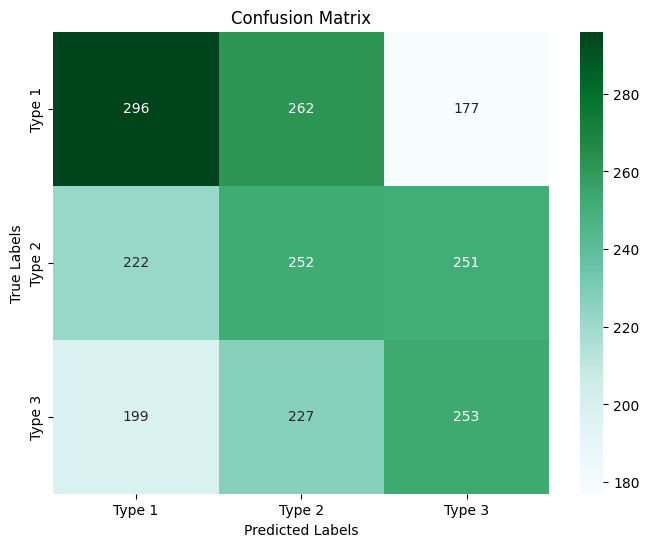

In [9]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Taining Curves

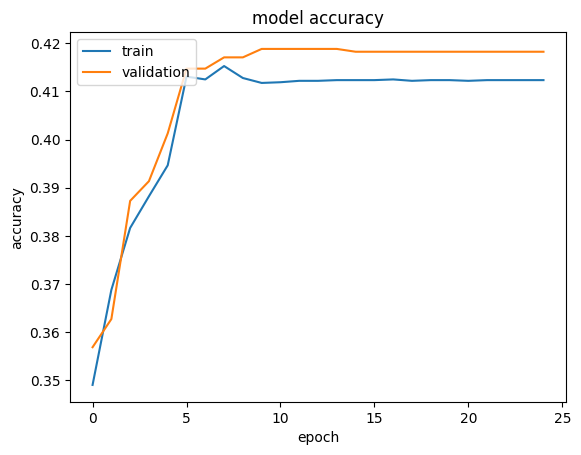

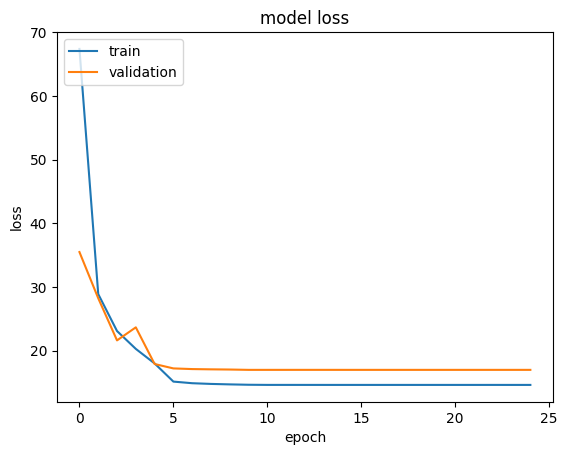

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()